# DRS calibration constant: TriggerOffset

Some people saw "problems" with the DRS4 calibration constant named "TriggerOffset", such as spikes in the calibrated data, when utilizing TriggerOffset. The question came up, if we need this TriggerOffset calibration at all. In this study I try to find out a little bit more about it in order to maybe find an answer or open up the discussion to define what else needs to be studied. 

This study is based on a random selection of 978 files with ROI=300 and fDrsStep=2. (Only 4 of which were uploaded into this repo to serve as example files, the rest please download yourself from ISDC). A complete list of the used filenames one can find at the end of this document.

**Data selection:**

I cut off the first 20 and the last 50 slices, as it is often done in the analysese as well, and I do not want to point out problems, which occur only in the edge parts of the calibration constant, which are later not taken into account. Such "problems at the edge" are no problem really.

This study is conducted on a random sample of 978 drs.fits files, roughly 10% of the entire amount of drs files FACT recorded within the 5 years of its operation.

**units:**

 * the time unit is slices. 
 * the amplitude of the TriggerOffset is not ADC units but it is stored as mV, I belive. So a single-pe amplitude is ~9..10 of these units.

### Overview

First, in order to get an impression, I show the constant for a random selection of 7 pixels in the camera for the 4 files supplied within this repo.

### Linear fit: Slope + Intercept

I believe the TriggerOffset was introduced, since one saw a residual systematic offset from zero, after applying the DRS calibration consisting only of (Baseline, Gain). And since the deviation from zero was systematic, why not measure it and get rid of it? So TriggerOffset was born. 

I think the measurement of TriggerOffset might have its problems. One might better apply a calibration consisting of (Baseline, Gain) to the raw data for step 2 **and** apply spike and jump removal **before** calculating TriggerOffset from that raw data. This way one might get rid of these artefacts within TriggerOffset.

Well now we have these artifacts. So I think, why not gather only the interesting information from TriggerOffset, which is the slope and the intercept. 

I perform a simple linear regression to the TriggerOffset per pixel and file. I do not treat any of the visible artifacts at all and merely *hope* they might average out over the files. Anyway this of course leads to a systematic error.

I find a significant deviation of the intercept from zero. To me it is unclear how this can be. The DRS4 calibration constant "BaselineMean" should get rid of any constant. I plot the mean intercept for all pixels in the camera as well as the std error of the mean. 

The mean measured slopes lie between -2.5uV/slice and +4.5uV/slice. So both negative and positive slopes are being measured. The typical std error of the mean is 0.13 uV/slice. 
The impact of such slopes between -2.5uV/slice and +4.5uV/slice on an integration window of 30 slices varies between -1.1mV slices and + 2.0mV slices. Where the integral of a single pe is ~240mV slices.

### Spikes:

Yifan Chen saw in her study (october 2015) about long term DRS4 calibration constants already spikes in the data when using TriggerOffset and no spikes when using her model, which did not take TriggerOffset into account. 
So I assumed the existence of spikes in the TriggerOffset lead to spikes in the data when applied. 

I try to find spikes within all pixels in my 978 file sample set. For this I convolute the TriggerOffset with a [-0.5, 1, -0.5] kernel to get rid of all slow variations and find quick changes in height. 

I plot some sample TriggerOffsets where the maximum response of the calibration constant with this kernel yields more than an arbitrary limit of 2. Note, the kernel is not normalized.

Out of these 978 files 85 show spikes according to this criterium. The majority of which show spikes in ~50 pixels (nb. the FACT camera contains 40 DRS4 boards, but 160 DRS4 chips). 

## Fazit:

If this little study is represensative, about 8.7% of our calibration files contain spikes in the order of 3..4mV in ~3.5% of their TriggerOffset parameters. Jumps with heights in the order of ~1mV are clearly visible and much more abundant. 
In case the purpose of TriggerOffset is to treat an additional offset and slope in the baseline, it might be possible to measure this offset and slope using the existing DRS4 calibration files from ~5 years with a simple fit.
The resulting offsets and slopes could be applied instead of applying the "raw" TriggerOffsets, preventing the introduction of named spikes and jumps into the data. However the magnitude of all slopes is very small and I see little reason to apply them at all. The additional Offsets (named "intercepts" within this study) are not neglectable and should be applied in one way or another.

In [1]:
import pandas as pd
from tqdm import tqdm
from glob import glob, iglob
from astropy.io import fits
import matplotlib.pyplot as plt
%matplotlib inline
from fact import plotting
import numpy as np
np.random.seed(2)

In [2]:
pixel = np.random.randint(0, 1440, 7)
pixel

array([1192,  527,  493,  299,  466, 1099,  360])

In [3]:
paths = glob('data/*')
file_ids = np.random.choice(len(paths), 4, replace=False)
paths = [paths[i] for i in file_ids]
paths

['data/20160921_067.drs.fits.gz',
 'data/20140707_008.drs.fits.gz',
 'data/20160913_117.drs.fits.gz',
 'data/20131203_113.drs.fits.gz']

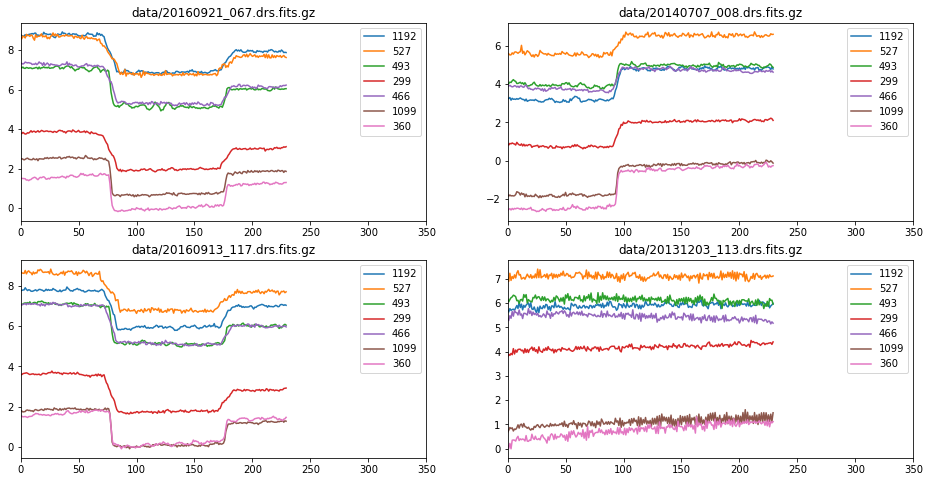

In [4]:
fig, axes = plt.subplots(2, 2, figsize=(16, 8))
for i,p in enumerate(paths):
    ax = axes.flatten()[i]
    f = fits.open(p)
    c = f[1].data['TriggerOffsetMean'].reshape(1440, -1)[:, 20:-50].T
    for i in pixel:
        ax.plot(c[:, i], label=str(i))
    ax.set_xlim(0, 350)
    ax.set_title(p)
    ax.legend()
None

## Slopes & Intercepts

In [5]:
slopes = []
intercepts = []
paths = glob('data/*')
for p in tqdm(paths):
    f = fits.open(p)
    c = f[1].data['TriggerOffsetMean'].reshape(1440, -1)[:, 20:-50].T
    fit = np.polyfit(np.arange(c.shape[0]), c, 1)
    slope = fit[0]
    slopes.append(slope)
    intercept = fit[1]
    intercepts.append(intercept)
slopes = np.array(slopes)
intercepts = np.array(intercepts)

100%|██████████| 978/978 [07:40<00:00,  2.18it/s]


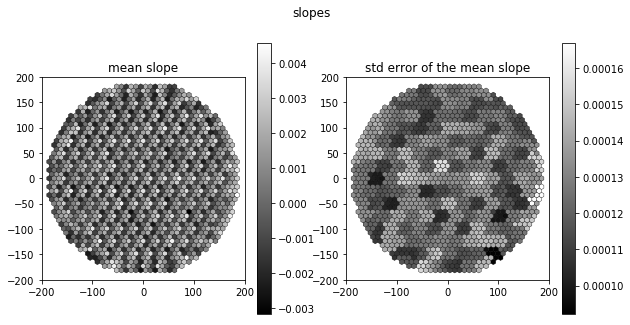

In [6]:
slope_m = slopes.mean(axis=0)
slope_s = slopes.std(axis=0) / np.sqrt(slopes.shape[0])

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

img = plotting.camera(
    slope_m,
    ax=axes[0]
)
fig.colorbar(img, ax=axes[0])
axes[0].set_title("mean slope")

img = plotting.camera(
    slope_s,
    ax=axes[1]
)
fig.colorbar(img, ax=axes[1])
axes[1].set_title("std error of the mean slope")

plt.suptitle("slopes")
None

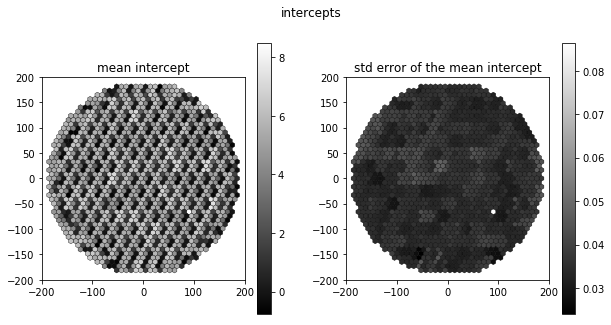

In [7]:
intercepts_m = intercepts.mean(axis=0)
intercepts_s = intercepts.std(axis=0) / np.sqrt(intercepts.shape[0])

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

img = plotting.camera(
    intercepts_m,
    ax=axes[0]
)
fig.colorbar(img, ax=axes[0])
axes[0].set_title("mean intercept")

img = plotting.camera(
    intercepts_s,
    ax=axes[1]
)
fig.colorbar(img, ax=axes[1])
axes[1].set_title("std error of the mean intercept")

plt.suptitle("intercepts")
None

## Find Spikes using convolution

In [8]:
results = []
for p in tqdm(paths):
    f = fits.open(p)
    c = f[1].data['TriggerOffsetMean'].reshape(1440, -1)[:, 20:-50]
    d = np.zeros((1440, c.shape[1]-2), dtype='f4')
    for i in range(1440):
        d[i] = np.convolve(
            [-0.5, 1, -0.5],
            c[i], 
            mode='valid')
    m = np.abs(d).max(axis=1)
    for chid in np.where(m > 2)[0]:
        results.append((
            m[chid],
            chid, 
            c[chid],
            p
        ))

100%|██████████| 978/978 [07:20<00:00,  2.16it/s]


In [9]:
len(results)

4453

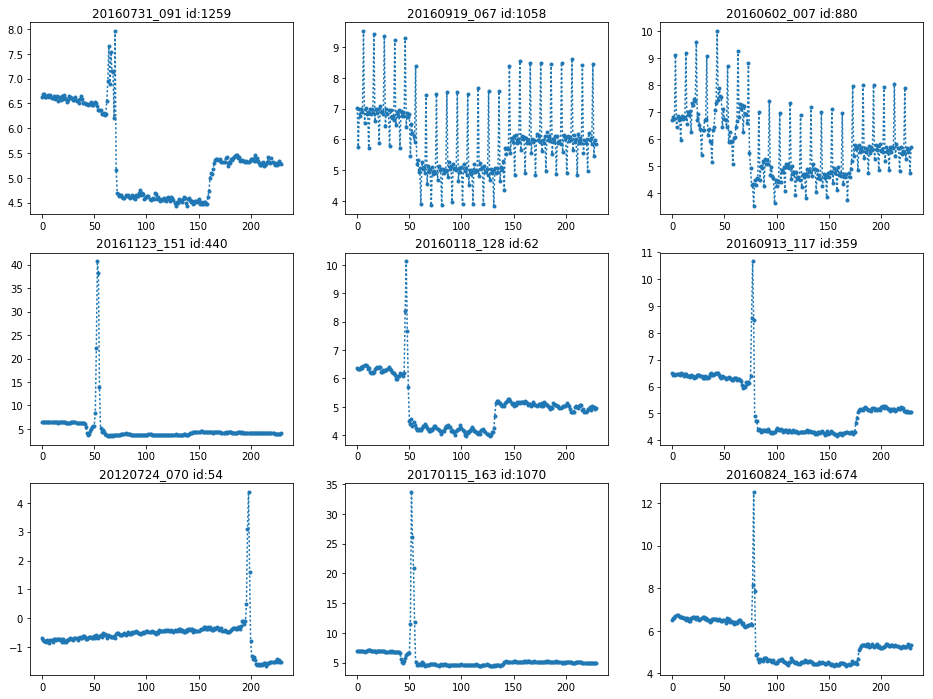

In [10]:
np.random.seed(0)
fig, axes = plt.subplots(3, 3, figsize=(16, 12))
some_results = [results[i] for i in np.random.choice(len(results), 9, replace=False)]
for i, (m, chid, d, p) in enumerate(some_results):
    ax = axes.flatten()[i]
    ax.set_title(p[5:-12] +" id:" + str(chid))
    ax.plot(d, '.:')

In [11]:
df = pd.DataFrame(results, columns=["max_response", "chid", "data", "path"])
df['path'] = df.path.str.slice(5, -12)
df.drop('data', axis=1, inplace=True)
df.sort_values('path', inplace=True)
len(df.path.unique())

85

In [12]:
print("{0:2.1f}% of drs files show spikes".format(
    100 * len(df.path.unique()) / len(paths))
     )

8.7% of drs files show spikes


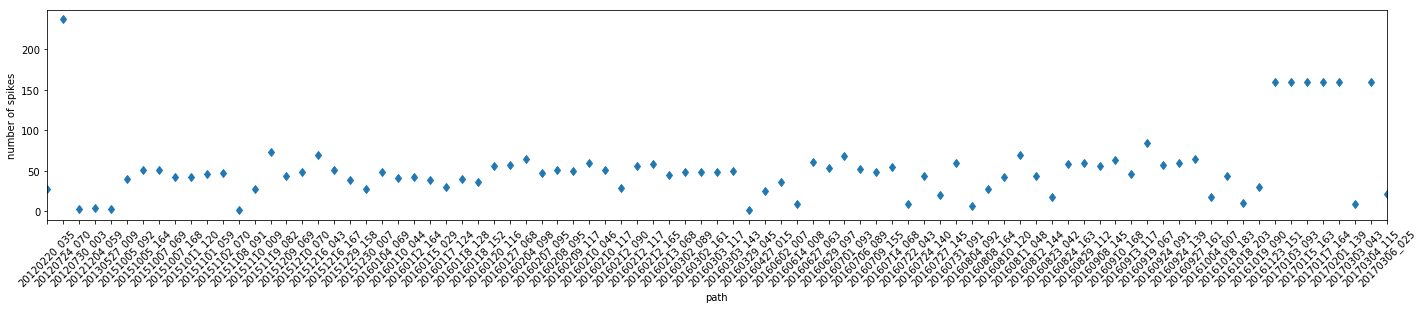

In [13]:
plt.figure(figsize=(24,4))
foo = df.groupby('path').count()
foo.max_response.plot(marker='d', lw=0)
plt.xticks(
    np.arange(len(df.path.unique())),
    df.path.unique(),
    rotation='45')
plt.subplots_adjust(bottom=0.15)
plt.ylabel('number of spikes')
None

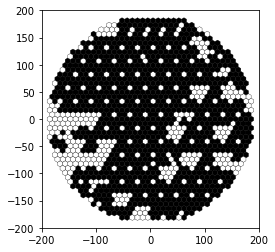

In [14]:
spike_seen = np.zeros(1440)
spike_seen[df.chid.unique()] = 1
plotting.camera(spike_seen)
None

In [15]:
ls data/

20111122_008.drs.fits.gz  20130823_072.drs.fits.gz  20151129_154.drs.fits.gz
20111122_015.drs.fits.gz  20130825_074.drs.fits.gz  20151201_138.drs.fits.gz
20111122_069.drs.fits.gz  20130825_203.drs.fits.gz  20151203_166.drs.fits.gz
20111124_015.drs.fits.gz  20130826_099.drs.fits.gz  20151209_069.drs.fits.gz
20111127_011.drs.fits.gz  20130827_070.drs.fits.gz  20151210_070.drs.fits.gz
20111128_014.drs.fits.gz  20130829_082.drs.fits.gz  20151210_167.drs.fits.gz
20111128_127.drs.fits.gz  20130830_045.drs.fits.gz  20151210_216.drs.fits.gz
20111202_024.drs.fits.gz  20130831_045.drs.fits.gz  20151216_043.drs.fits.gz
20111202_065.drs.fits.gz  20130901_007.drs.fits.gz  20151216_167.drs.fits.gz
20111203_003.drs.fits.gz  20130901_020.drs.fits.gz  20151218_007.drs.fits.gz
20111203_009.drs.fits.gz  20130902_123.drs.fits.gz  20151220_043.drs.fits.gz
20111207_003.drs.fits.gz  20130903_123.drs.fits.gz  20151221_022.drs.fits.gz
20111212_043.drs.fits.gz  20130906_007.drs.fits.gz  20151229_158.drs.fits.gz